# Matthew Makila: HW 2

In [36]:
import math
import pandas as pd
import copy
import time
import numpy as nump
import matplotlib.pyplot as plt

### File import functions for the 3 datasets

In [37]:
def file_import(f_name):    # for mileage data
    # specify features and the response var for file extraction and storage as a table
    feat_names = ['mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']
    f_feat_names = ['x0', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']
    df = pd.read_csv(f_name, usecols=feat_names)
    resp_vect = df['mpg'].values.tolist()

    # scale the features
    scale_df = ((df - df.mean()) / df.std())

    # add vector for x0 of 1's; remove the response var
    x_0 = []
    for i in range(len(resp_vect)): x_0.append(1)
    scale_df = scale_df.drop('mpg', axis='columns')
    scale_df.insert(0, "x0", x_0, True)

    # create feature matrix to store all scaled features
    feat_matrix = []
    for feat in f_feat_names:
        feat_matrix.append(scale_df[feat].values.tolist())
    return feat_matrix, resp_vect

In [38]:
def file_import2(f_name):   # for cancer data
    df = pd.read_csv(f_name)
    resp_vect = df['LungCancer'].values.tolist()
    # add vector for x0 of 1's; remove the response var
    x_0 = []
    for i in range(len(resp_vect)): x_0.append(1)
    df = df.drop('LungCancer', axis='columns')
    df.insert(0, "x0", x_0, True)
    feat_names = ['x0', 'Smoking']
    feat_mat = df.values.tolist()

    return feat_mat, resp_vect

In [39]:
def file_import3(filename):
    df = pd.read_csv(filename)
    X = df.iloc[:, 1:].copy()
    # X = (X - X.mean()) / X.std()
    X['x0'] = 1
    cols = X.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    X = X[cols]

    X = nump.matrix(X)
    y = nump.transpose(nump.matrix(df['Species']))

    return X, y

### Gradient Descent Function for Model Training

In [40]:
def gradient_descent(X, y, alpha, model):
    # create vector to hold the theta values (past and present), initialize our theta vectors to 0
    start = time.time()
    runtime = 0
    iteration_list = []
    iterations = 0
    threshold = 0.00001
    m = len(y)  # number of observations
    thetas = []
    old_thetas = []
    diff_vect = []
    costs = []
    if model == 'linear':
        for i in range(len(X)):
            thetas.append(0)
            old_thetas.append(0)
            diff_vect.append(0)
    else:
        thetas = nump.zeros(len(X[0]))
        old_thetas = nump.zeros(len(X[0]))
        diff_vect = nump.zeros(len(X[0]))
    not_converged = True
    true_count = 0
    while not_converged:
        # loop over GDA equation algorithm
        for j in range(len(thetas)):    # loop to update each feature
            g_sum = 0
            for i in range(m):  # loop to compute each summation over all observations
                h_theta_x = 0
                if model == 'linear':
                    for n in range(len(thetas)):
                        h_theta_x += (old_thetas[n] * X[n][i])
                elif model == 'cancer':
                    p = -1 * (nump.dot(old_thetas, nump.array(X[i])))
                    h_theta_x = (1 / (1 + math.exp(p)))
                else:
                    p = -1 * (nump.dot(old_thetas, X[i]))
                    h_theta_x = (1 / (1 + math.exp(p)))
                if model == 'linear':
                    g_sum += (X[j][i] * (h_theta_x - y[i]))
                else:
                    g_sum += (X[i][j] * (h_theta_x - y[i]))
            # add back to new theta here
            thetas[j] = old_thetas[j] - (alpha / m) * g_sum
        # check differences of new thetas will old thetas & check threshold
        for i in range(len(thetas)):
            diff_vect[i] = abs(thetas[i] - old_thetas[i])
            if diff_vect[i] < threshold:
                true_count += 1

        # if all differences are less than threshold, we converged
        if true_count == len(diff_vect):
            not_converged = False
            end = time.time()
            runtime = end-start
        else:
            # update old thetas to continue GDA next iteration
            true_count = 0
            for i in range(len(thetas)):
                old_thetas[i] = thetas[i]
    return thetas, runtime, costs, iteration_list

### Helper functions to solve Question 1

In [41]:
def mpg_estimate(X, y, Theta):
    # create a vector of estimations (y hat)
    y_hat = []
    theta = nump.array(Theta)
    for i in range(len(y)):
        sample = []
        for j in range(len(X)):
            sample.append(X[j][i])
        # calculate a y hat with numpy: multiply theta transpose by that sample's features
        new_X = nump.array(sample)
        y_hat.append(nump.dot(theta, new_X))
    # calculate the error between observed and predicted
    calc_errors(y, y_hat, X)


def calc_errors(y, y_hat, X):
    error = nump.array(y) - nump.array(y_hat).T
    data = {'Observed mileage': y, 'Estimated mileage': y_hat, 'Error': error}
    df = pd.DataFrame(data=data)
    print(df)
    # calculate R^2 and adjusted R^2
    SSR = pow(error, 2)
    SST = pow((nump.array(y) - nump.array(nump.mean(y)).T), 2)
    R_Sq = 1 - (sum(SSR) / sum(SST))
    A_R_Sq = 1 - (1 - R_Sq) * ((len(y) - 1) / (len(y) - len(X)))
    print("R-Squared: ", R_Sq)
    print("Adjusted R-Squared: ", A_R_Sq)


def LOOCV(X, y, alpha, model):
    m = len(y)
    n = len(X)
    y_hat = []
    for i in range(m):
        # remember original intact matrices for X and y while we remove 1 at a time
        n_X = copy.deepcopy(X)
        n_y = copy.deepcopy(y)
        # begin removals
        feat_to_predict = []
        n_y.pop(i)
        for j in range(n):  # save & remove all features of a specific example to predict later
            feat_to_predict.append(n_X[j][i])
            n_X[j].pop(i)

        theta, run, cost, it = gradient_descent(n_X, n_y, alpha, 'linear')   # with 1 left out
        y_hat.append(nump.dot(theta, feat_to_predict))
    calc_errors(y, y_hat, X)

    
def k_calc_errors(y, y_hat, X):
    Rs = []
    A_Rs = []
    for i in range(len(X) - 1):
        error = nump.array(y) - nump.array(y_hat[i]).T
        # calculate R^2 and adjusted R^2
        SSR = sum(pow(error, 2))
        SST = sum(pow((nump.array(y) - nump.array(nump.mean(y)).T), 2))
        R_Sq = 1 - (SSR / SST)
        A_R_Sq = 1 - (1 - R_Sq) * ((len(y) - 1) / (len(y) - len(X)))
        Rs.append(R_Sq)
        A_Rs.append(A_R_Sq)
    plot_rs(Rs, A_Rs)
    
    
def k_feat_calc(X, y, alpha):
    y_hat = []
    n = len(X)
    for i in range(n + 1):
        theta, run, cost, it = gradient_descent(X[:i + 1], y, alpha, 'linear')  # with 1 left out
        y_hat.append(nump.dot(theta, X[:i + 1]))
    y_hat.pop(0)    # destroy first set
    k_calc_errors(y, y_hat, X)
    

def plot_rs(R, A_R):
    x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    plt.plot(x, R, label='R-Squared')
    plt.plot(x, A_R, label='Adjusted R-Squared')
    plt.legend()
    plt.ylabel("R-Squared Values")
    plt.xlabel("Number of features")
    plt.show()

### 1. (A) (Predict car mileage using MLR, report errors, and report R-squared values)

In [42]:
X_, y_ = file_import('mileage.csv')
a = 0.2
"""1"""
# 1A
Thetas, runtime, costs, iterations = gradient_descent(X_, y_, a, 'linear')
mpg_estimate(X_, y_, Thetas)

    Observed mileage  Estimated mileage     Error
0               21.0          22.598999 -1.598999
1               21.0          22.111664 -1.111664
2               22.8          26.251209 -3.451209
3               21.4          21.236887  0.163113
4               18.7          17.692871  1.007129
5               18.1          20.383144 -2.283144
6               14.3          14.385650 -0.085650
7               24.4          22.495915  1.904085
8               22.8          24.418683 -1.618683
9               19.2          18.699417  0.500583
10              17.8          19.191877 -1.391877
11              16.4          14.173373  2.226627
12              17.3          15.600147  1.699853
13              15.2          15.742774 -0.542774
14              10.4          12.033212 -1.633212
15              10.4          10.936323 -0.536323
16              14.7          10.494081  4.205919
17              32.4          27.773308  4.626692
18              30.4          29.895863  0.504137


##### We can see in this portion that the R-squared and adjusted R-squared values are relatively high (both higher than 0.8) and that the errors between observations are not ever more/less than 5 mpg.

### 1. (B) (Predict car mileage using LOOCV with MLR, report errors, and report R-squared values)

In [43]:
# 1B
LOOCV(X_, y_, a, 'linear')

    Observed mileage  Estimated mileage     Error
0               21.0          23.292471 -2.292471
1               21.0          22.566202 -1.566202
2               22.8          27.334015 -4.534015
3               21.4          21.188796  0.211204
4               18.7          17.441872  1.258128
5               18.1          21.281126 -3.181126
6               14.3          14.426968 -0.126968
7               24.4          21.557089  2.842911
8               22.8          29.079083 -6.279083
9               19.2          18.322931  0.877069
10              17.8          20.026541 -2.226541
11              16.4          13.204039  3.195961
12              17.3          15.195904  2.104096
13              15.2          15.899143 -0.699143
14              10.4          13.011010 -2.611010
15              10.4          11.176202 -0.776202
16              14.7           8.633541  6.066459
17              32.4          26.764896  5.635104
18              30.4          29.366959  1.033041


##### We can see in this portion that the R-squared and adjusted R-squared values are worse than the previous model's and that the errors between observations are much higher than the previous model's as well.

### 1. (C) (Predict car mileage using MLR with k mean features and report R-squared values graphically)

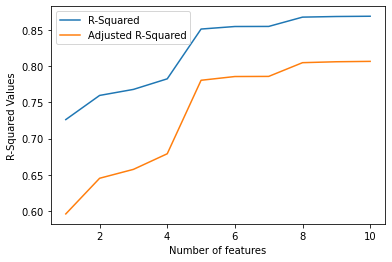

In [44]:
# 1C
k_feat_calc(X_, y_, a)

##### We can see in this portion that the R-squared and adjusted R-squared increase with the addition of new features, but do not significantly change beyond the 5th feature's addition

### Function for Cancer Predictions in Question 2

In [45]:
def pred_cancer(X, y, theta):
    y_hat = []
    threshold = 0.5
    m = len(y)
    for i in range(m):
        p = -1 * (nump.dot(theta, nump.array(X[i])))
        h_theta_x = (1 / (1 + math.exp(p)))
        if h_theta_x <= threshold:  # if predictor is less than 0.5, we have class 0
            y_hat.append(0)
        else:
            y_hat.append(1)
    TP = 0
    TN = 0
    P = 0
    N = 0
    PP = 0

    for i in range(m):
        # count our classifications
        if y_hat[i] == y[i]:    # correct if match
            if y_hat[i] == 1:   # TP if eq 1, else TN
                TP += 1
            else:
                TN += 1
        if y[i] == 1:
            P += 1
        else:
            N += 1
        if y_hat[i] == 1:
            PP += 1

    confuse = pd.crosstab(y, y_hat, rownames=['Actual'], colnames=
                          ['Predicted'], margins=True)
    correct_class = (TP + TN) / m
    precision = TP / PP
    recall = TP / P
    specificity = TN / N
    f1 = 2 / (pow(precision, -1) + pow(recall, -1))

    print(confuse)
    print("Correct % of classifications:\t", correct_class)
    print("Precision:\t", precision)
    print("Recall:\t", recall)
    print("Specificity:\t", specificity)
    print("F1:\t", f1)
    print("Odds Ratio:\t", math.exp(theta[1]))

### 2. (A) (Learning logistic regression hypothesis for lung cancer as a function of smoking)

In [46]:
"""2"""
# 2A
X1, y1 = file_import2('cancer.csv')
Thetas2, runtime2, costs2, iterations2 = gradient_descent(X1, y1, a, 'cancer')
print(Thetas2)

[-0.22245295  0.62752791]


### 2. (B) (Classifying each individual as having lunger cancer or not, reporting the confusion matrix and other statistically significant results)

In [47]:
# 2B
pred_cancer(X1, y1, Thetas2)

Predicted  0   1  All
Actual               
0          5   4    9
1          4   6   10
All        9  10   19
Correct % of classifications:	 0.5789473684210527
Precision:	 0.6
Recall:	 0.6
Specificity:	 0.5555555555555556
F1:	 0.6
Odds Ratio:	 1.8729746880712026


##### We can see that the model is not too accurate in correctly classifying cancer predictions, but it is at least near 60% accurate. 

### 2. (C)

##### Using the calculated Odds ratio, I think it can be determined that smokers are about 1.87 times as likely to develop cancer than non-smokers are.

### Functions written to assist with Question 3's scaling and predictions

In [48]:
def scaling(X):
    X1 = pd.DataFrame(X)

    X1 = X1.drop(0, axis='columns')
    mean = X1.mean()    # save these for later
    std = X1.std()
    X1 = (X1 - X1.mean()) / X1.std()
    X1.insert(0, 0, 1, True)
    X1 = X1.values.tolist()

    return X1, mean, std


def scaling2(X, mean, std):
    X = pd.DataFrame(X)
    X = X.drop(0, axis='columns')
    X = (X - mean) / std
    X.insert(0, 0, 1, True)
    X = X.values.tolist()
    return X


def pred_flower(X, y, theta):
    y = y.tolist()
    y = [j for sub in y for j in sub]
    y_hat = []
    m = len(y)

    for i in range(m):
        h_set = (1 / (1 + math.exp(-1 * (nump.dot(theta[0], X[i])))))
        h_ver = (1 / (1 + math.exp(-1 * (nump.dot(theta[1], X[i])))))
        h_vir = (1 / (1 + math.exp(-1 * (nump.dot(theta[2], X[i])))))
        p = max(h_set, h_ver, h_vir)
        if p == h_set:
            y_hat.append('setosa')
        elif p == h_ver:
            y_hat.append('versicolor')
        else:
            y_hat.append('virginica')

    T = 0
    Set_T = 0
    Ver_T = 0
    Vir_T = 0

    for i in range(m):
        # count our classifications
        if y_hat[i] == y[i]:  # correct if match
            T += 1
            if y_hat[i] == 'setosa':
                Set_T += 1
            if y_hat[i] == 'versicolor':
                Ver_T += 1
            if y_hat[i] == 'virginica':
                Vir_T += 1

    confuse = pd.crosstab(y, y_hat, rownames=['Actual'], colnames=['Predicted'], margins=True)
    correct_class = T / m
    Set_correct = Set_T / (m/3)
    Ver_correct = Ver_T / (m/3)
    Vir_correct = Vir_T / (m/3)

    print(confuse)
    print("Overall Correct % of Classifications:\t", correct_class)
    print("Setosa Correct % of Classifications:\t", Set_correct)
    print("Versicolor Correct % of Classifications:\t", Ver_correct)
    print("Virginica Correct % of Classifications:\t", Vir_correct)

### 3. (A) (Separate data in training and test data using an 80-20 split)

In [49]:
"""3"""
# 3A - Divide into test and train data sets
X2, y_f = file_import3('flowers.csv')
y_1 = nump.transpose(nump.matrix([1 if val == 'setosa' else 0 for val in y_f]))
y_2 = nump.transpose(nump.matrix([1 if val == 'versicolor' else 0 for val in y_f]))
y_3 = nump.transpose(nump.matrix([1 if val == 'virginica' else 0 for val in y_f]))

rows = [i for i in range(X2.shape[0])]
trainRows = [i for i in range(0, 40)] + [i for i in range(50, 90)] + [i for i in range(100, 140)]
testRows = sorted(list(set.difference(set(rows), set(trainRows))))

XTrain = X2[trainRows, :]   # scale me
yTrain = y_f[trainRows, :]

y1Train = y_1[trainRows, :]
y2Train = y_2[trainRows, :]
y3Train = y_3[trainRows, :]

XTest = X2[testRows, :]     # scale me with XTrain's mean and std
yTest = y_f[testRows, :]

y1Test = y_1[testRows, :]
y2Test = y_2[testRows, :]
y3Test = y_3[testRows, :]

### 3. (B) (Scale the training data and the test data using the mean and variance from the training set)

In [50]:
# 3B - Scaling
XTrainScaled, X_mean, X_std = scaling(XTrain)
XTestScaled = scaling2(XTest, X_mean, X_std)

### 3. (C) (Train the three different models using the training set to determine probabilites of a flower being in a particular species)

In [16]:
# 3C - Learn probabilities with 3 separate models for classification
# model 1 (setosa)
Thetas_s, runtime_s, costs_s, iterations_s = gradient_descent(XTrainScaled, y1Train, a, 'logistic')
print(Thetas_s)

# model 2 (versicolor)
Thetas_versi, runtime_versi, costs_versi, iterations_versi = gradient_descent(XTrainScaled, y2Train, a, 'logistic')
print(Thetas_versi)

# model 3 (virginica)
Thetas_virg, runtime_virg, costs_virg, iterations_virg = gradient_descent(XTrainScaled, y3Train, a, 'logistic')
print(Thetas_virg)

[-5.24334614 -1.75999339  3.9898382  -4.42729052 -4.45791134]
[-0.94861559  0.27162912 -1.38605387  0.61796515 -0.89460269]
[-18.70584143  -1.99562271  -2.78318499  15.79802893  12.91789495]


### 3. (D) (Classify each flower from the training data set using the learned proabilities)

In [17]:
# 3D - Predictions using training data
pred_flower(XTrainScaled, yTrain, [Thetas_s, Thetas_versi, Thetas_virg])

Predicted   setosa  versicolor  virginica  All
Actual                                        
setosa          40           0          0   40
versicolor       0          38          2   40
virginica        0           1         39   40
All             40          39         41  120
Overall Correct % of Classifications:	 0.975
Setosa Correct % of Classifications:	 1.0
Versicolor Correct % of Classifications:	 0.95
Virginica Correct % of Classifications:	 0.975


##### We can observe the model does very well in correctly classifying all the training data flowers based upon their species using the given features. Each species is correctly identified with the exception of 3 samples in the entire set of 120.

### 3. (E) (Classify each flower from the testing data set using the learned proabilities)

In [18]:
# 3E - Predictions using test data
pred_flower(XTestScaled, yTest, [Thetas_s, Thetas_versi, Thetas_virg])

Predicted   setosa  versicolor  virginica  All
Actual                                        
setosa          10           0          0   10
versicolor       0          10          0   10
virginica        0           0         10   10
All             10          10         10   30
Overall Correct % of Classifications:	 1.0
Setosa Correct % of Classifications:	 1.0
Versicolor Correct % of Classifications:	 1.0
Virginica Correct % of Classifications:	 1.0


##### We can observe the model does perfectly in classifying all the test data flowers based upon their species using the given features. Each species is correctly identified from the entire test data set.

### Extra Credit Problem

In [ ]:
XTrainScaled = pd.DataFrame(XTrainScaled)
XTrainScaled = XTrainScaled.drop(1, axis='columns')
XTrainScaled = XTrainScaled.values.tolist()

# model 1 (setosa)
Thetas_s1, runtime_s1, costs_s1, iterations_s1 = gradient_descent(XTrainScaled, y1Train, a, 'logistic')
print(Thetas_s1)

# model 2 (versicolor)
Thetas_versi1, runtime_versi1, costs_versi1, iterations_versi1 = gradient_descent(XTrainScaled, y2Train, a, 'logistic')
print(Thetas_versi1)

# model 3 (virginica)
Thetas_virg1, runtime_virg1, costs_virg1, iterations_virg1 = gradient_descent(XTrainScaled, y3Train, a, 'logistic')
print(Thetas_virg1)
